# Model with conditional interaction

In this example, we show the heterogeneity of the global effects, using PDP, ALE, and RHALE, on a model with conditional interactions .
In particular, we:

1. show how to use `effector` to compute and visualie the heterogeneity of the global effects using PDP, ALE, and RHALE
2. find the heterogeneity of the global effects using analytical derivations
3. test that (1) and (2) match

We will use the following model: 

$$ 
f(x_1, x_2, x_3) = -x_1^2 \mathbb{1}_{x_2 <0} + x_1^2 \mathbb{1}_{x_2 \geq 0} + e^{x_3} 
$$

where the features $x_1, x_2, x_3$ are independent and uniformly distributed in the interval $[-1, 1]$.


The model has an _interaction_ between $x_1$ and $x_2$ caused by the terms: 
$f_{1,2}(x_1, x_2) = -x_1^2 \mathbb{1}_{x_2 <0} + x_1^2 \mathbb{1}_{x_2 \geq 0}$.
This means that the effect of $x_1$ on the output $y$ depends on the value of $x_2$ and vice versa.
Terms like this introduce heterogeneity.
Each global effect method has a different formula for qunatifying such heterogeneity; below, we will see how PDP, ALE, and RHALE handles it.

In contrast, $x_3$ does not interact with any other feature, so its global effect has zero heterogeneity.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import effector

np.random.seed(21)

model = effector.models.ConditionalInteraction()
dataset = effector.datasets.IndependentUniform(dim=3, low=-1, high=1)
x = dataset.generate_data(10_000)

## PDP

### Effector

Let's see below the PDP heterogeneity for each feature, using `effector`.

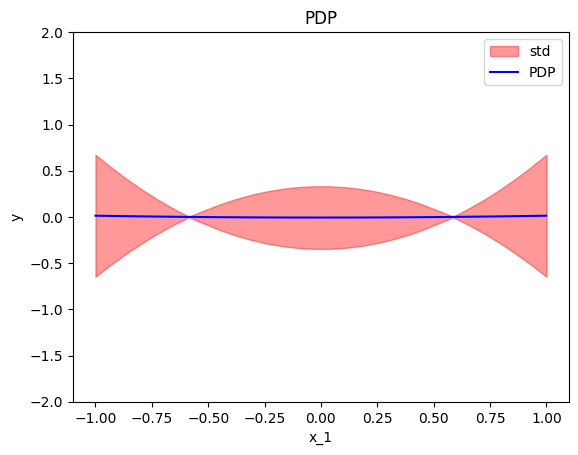

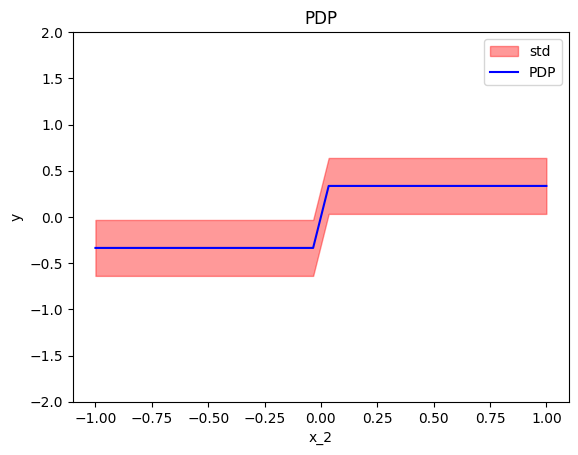

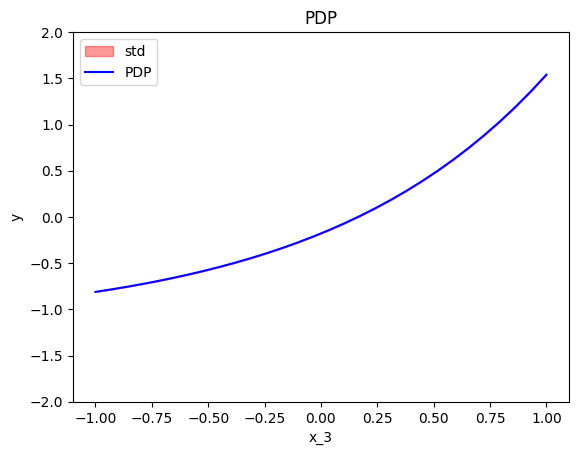

In [20]:
pdp = effector.PDP(x, model.predict, dataset.axis_limits)
pdp.fit(features="all", centering=True)
for feature in [0, 1, 2]:
    pdp.plot(feature=feature, centering=True, heterogeneity=True, y_limits=[-2, 2])

In [21]:
pdp = effector.PDP(x, model.predict, dataset.axis_limits, nof_instances="all")
pdp.fit(features="all", centering=True)
heter_per_feat = []
for feature in [0, 1, 2]:
    y_mean, y_var = pdp.eval(feature=feature, xs=np.linspace(-1, 1, 100), centering=True, heterogeneity=True)
    print(f"Heterogeneity of x_{feature}: {y_var.mean():.3f}")
    heter_per_feat.append(y_var.mean())

Heterogeneity of x_0: 0.092
Heterogeneity of x_1: 0.088
Heterogeneity of x_2: 0.000


In [4]:
feature = 0
yy = pdp.eval(feature=feature, xs=np.linspace(-1, 1, 100), centering=True, heterogeneity=True, return_all=True)

In [5]:
print(yy.shape)
yy[:,0]

(100, 300)


array([-0.65993266, -0.61993674, -0.58075707, -0.54239363, -0.50484644,
       -0.4681155 , -0.4322008 , -0.39710234, -0.36282012, -0.32935415,
       -0.29670442, -0.26487093, -0.23385369, -0.20365269, -0.17426793,
       -0.14569942, -0.11794715, -0.09101112, -0.06489134, -0.0395878 ,
       -0.0151005 ,  0.00857055,  0.03142536,  0.05346393,  0.07468626,
        0.09509234,  0.11468218,  0.13345577,  0.15141312,  0.16855423,
        0.18487909,  0.20038772,  0.21508009,  0.22895623,  0.24201612,
        0.25425977,  0.26568717,  0.27629834,  0.28609326,  0.29507193,
        0.30323436,  0.31058055,  0.3171105 ,  0.3228242 ,  0.32772166,
        0.33180288,  0.33506785,  0.33751658,  0.33914907,  0.33996531,
        0.33996531,  0.33914907,  0.33751658,  0.33506785,  0.33180288,
        0.32772166,  0.3228242 ,  0.3171105 ,  0.31058055,  0.30323436,
        0.29507193,  0.28609326,  0.27629834,  0.26568717,  0.25425977,
        0.24201612,  0.22895623,  0.21508009,  0.20038772,  0.18

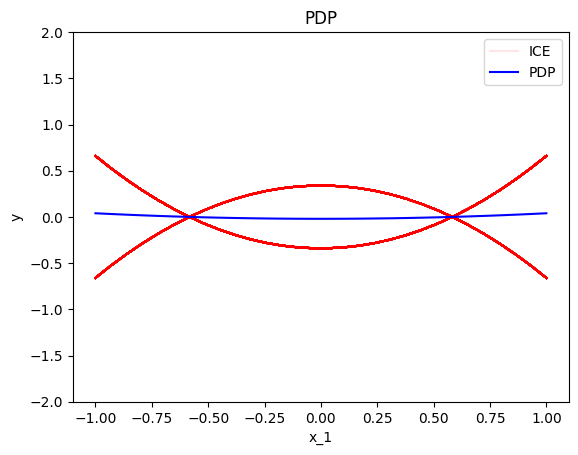

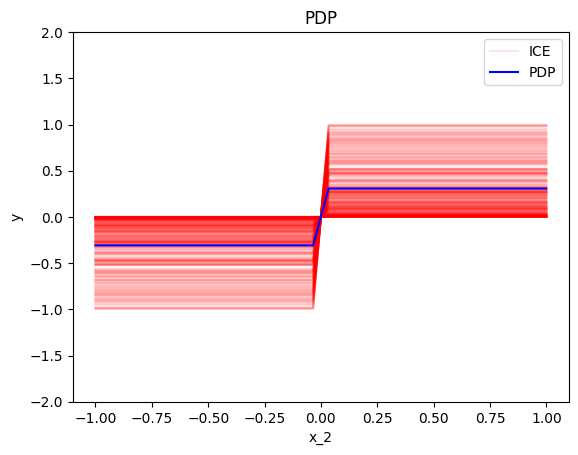

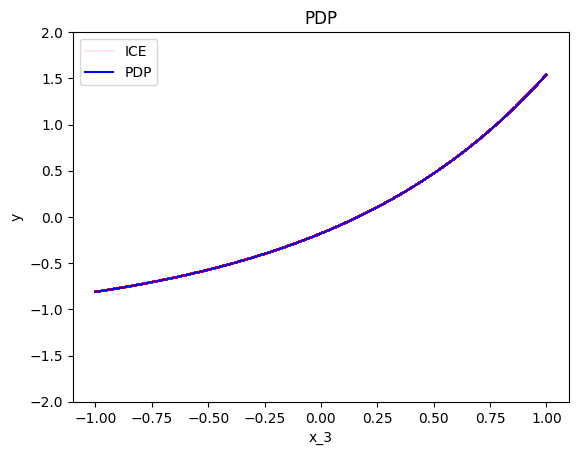

In [6]:
for feature in [0, 1, 2]:
    pdp.plot(feature=feature, centering=True, heterogeneity="ice", y_limits=[-2, 2])

PDP states that:

* $x_1$ has a zero average effect on the model output
* $x_2$ has a constant effect when $x_2 <0$ or $x_2 >0$, but when moving from $x_2^-$ to $x_2^+$ it adds (on average) $+\frac{2}{3}$ units to $y$
* $x_3$ has an effect of $e^{x_3}$

### Derivations

How PDP leads to these explanations? Are they meaningfull? Let's have some analytical derivations.
If you don't care about the derivations, skip the following three cells and go directly to the coclusions.

For $x_1$:

\begin{align}
PDP(x_1) &\propto \frac{1}{N} \sum_{i=1}^{n} f(x_1, \mathbf{x}^i_{/1}) \\
&\propto \frac{1}{N} \sum_{i=1}^{N} -x_1^2 \mathbb{1}_{x_2^i <0} + x_1^2 \mathbb{1}_{x_2^i \geq 0} + e^{x_3^i} \\
&\propto x_1^2 \frac{1}{N}\sum_{i=1}^{n} ( - \mathbb{1}_{x_2^i < 0} + \mathbb{1}_{x_2^i \geq 0}) \\
&\approx c
\end{align}

For $x_2$:

\begin{align}
PDP(x_2) &\propto \frac{1}{N} \sum_{i=1}^{n} f(x_2, \mathbf{x}_{/2}^i) \\
&\propto \frac{1}{N} \sum_{i=1}^{n} \left [ (-x_1^i)^2 \mathbb{1}_{x_2 < 0} + (x_1^i)^2 \mathbb{1}_{x_2 \geq 0} + e^{x_3^i} \right ] \\
&\propto \left [ \frac{1}{N} \sum_i^N -x_{i,1}^2 \right ] \mathbb{1}_{x_2 <0}  + \left [ \frac{1}{N} \sum_i^N x_{i,1}^2\right ] \mathbb{1}_{x_2 \geq 0}  \\
&\approx -\frac{1}{3} \mathbb{1}_{x_2 < 0} + \frac{1}{3} \mathbb{1}_{x_2 \geq 0} + c
\end{align}

For $x_3$:

\begin{align}
PDP(x_3) &\propto \frac{1}{N} \sum_{i=1}^{n} f(x_3, x_{/3}^i) \\
&\propto e^{x_3} + c\\
\end{align}

### Conclusions

Are the PDP effects intuitive?

* For $x_1$ the effect is zero. The terms related to $x_1$ are $-x_1^2 \mathbb{1}_{x_2 <0}$ and $x_1^2 \mathbb{1}_{x_2 \geq 0}$. Both terms involve an interaction with $x_2$. Since $x_2 \sim \mathcal{U}(-1,1)$, almost half of the instances have $x_2^i < 0$ and the the other half $x_2^i \geq 0$, so the the two terms cancel out.
* For $x_2$, the effect is constant when $x_2 < 0$ or $x_2>0$ but has a positive jump of $\frac{2}{3}$ when moving from $x_2^-$ to $x_2^+$. It makes sense; when $x_2 < 0$ the active term is $-(x_1^i)^2 \mathbb{1}_{x_2 < 0} $ which adds a negative quantity to the output and when $x_2 \geq 0$ the active term is $(x_1^i)^2 \mathbb{1}_{x_2 \geq 0}$ that adds something postive. Therefore in the transmission we observe a non-linearity.
* For $x_3$, the effect is  $e^{x_3}$, as expected, since only the this term corresponds to $x_3$ and has no interaction with other variables.

In [7]:
def compute_centering_constant(func, start, stop, nof_points):
    x = np.linspace(start, stop, nof_points)
    y = func(x)
    return np.mean(y)


def pdp_ground_truth(feature, xs):
    if feature == 0:
        ff = lambda x: np.zeros_like(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 1:
        ff = lambda x: -1 / 3 * (x < 0) + 1 / 3 * (x >= 0)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 2:
        ff = lambda x: np.exp(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z

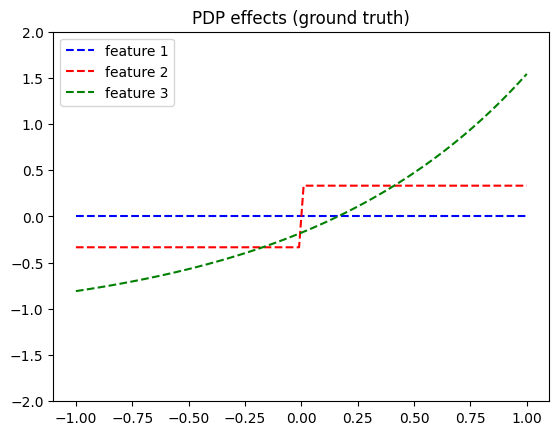

In [8]:
xx = np.linspace(-1, 1, 100)
y_pdp = []
for feature in [0, 1, 2]:
    y_pdp.append(pdp_ground_truth(feature, xx))

plt.figure()
plt.title("PDP effects (ground truth)")
color_pallette = ["blue", "red", "green"]
for feature in [0, 1, 2]:
    plt.plot(
        xx, 
        y_pdp[feature], 
        color=color_pallette[feature], 
        linestyle="--",
        label=f"feature {feature + 1}"
    )
plt.legend()
plt.xlim([-1.1, 1.1])
plt.ylim([-2, 2])
plt.show()


In [9]:
# make a test
xx = np.linspace(-1, 1, 100)
for feature in [0, 1, 2]:
    y_pdp = pdp.eval(feature=feature, xs=xx, centering=True)
    y_gt = pdp_ground_truth(feature, xx)
    np.testing.assert_allclose(y_pdp, y_gt, atol=1e-1)

## ALE

### Effector

Let's see below the PDP effects for each feature, using `effector`.

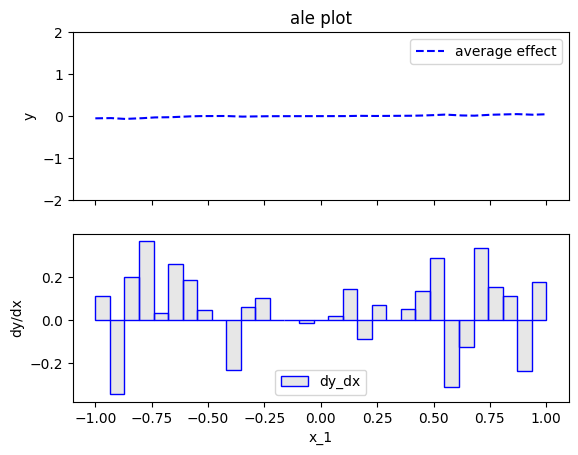

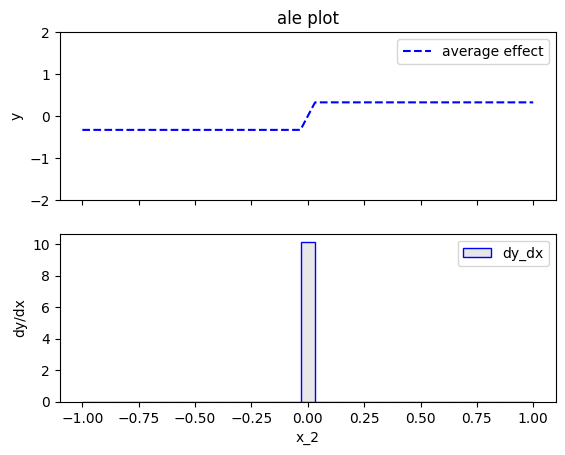

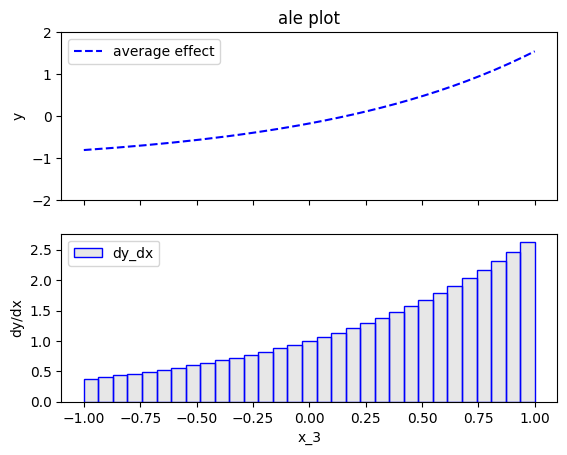

In [10]:
ale = effector.ALE(x, model.predict, axis_limits=dataset.axis_limits)
ale.fit(features="all", centering=True, binning_method=effector.binning_methods.Fixed(nof_bins=31))

for feature in [0, 1, 2]:
    ale.plot(feature=feature, centering=True, y_limits=[-2, 2])

ALE states that:
- $x_1$ has a zero average effect on the model output (same as PDP)
- $x_2$ has a constant effect when $x_2 <0$ or $x_2 >0$, but when moving from $x_2^-$ to $x_2^+$ it adds (on average) $+\frac{2}{3}$ units to $y$ (same as PDP)
- $x_3$ has an effect of $e^{x_3}$ (same as PDP)


### Derivations

\begin{align}
ALE(x_1) &\propto \sum_{k=1}^{k_{x_1}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^i \in \mathcal{S}_k} \left [  f(z_k, x^i_2, x^i_3) - f(z_{k-1}, x^i_2, x^i_3) \right ] \\
&\propto \sum_{k=1}^{k_{x_1}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left [ -z_k^2 \mathbb{1}_{x_2^i <0} + z_k^2 \mathbb{1}_{x_2^i \geq 0} + e^{x_3^i} - (-z_{k-1}^2 \mathbb{1}_{x_2^i <0} + z_{k-1}^2 \mathbb{1}_{x_2^i \geq 0} + e^{x_3^i} ) \right ] \\
&\propto \sum_{k=1}^{k_{x_1}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left [ -z_k^2 \underbrace{(\mathbb{1}_{x_2^i <0} - \mathbb{1}_{x_2^i \geq 0})}_{\approx 0} + z_{k-1}^2 \underbrace{(\mathbb{1}_{x_2^i <0} - \mathbb{1}_{x_2^i \geq 0})}_{\approx 0} \right ] \\
&\approx \sum_{k=1}^{k_{x_1}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} 0 \\
&\approx 0
\end{align}

\begin{align}
ALE(x_2) &\propto \sum_{k=1}^{k_{x_2}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left [  f(x_i^1, z_k, x^i_3) - f(x_i^1, z_{k-1}, x^i_3 \right ] \\
&\propto \sum_{k=1}^{k_{x_2}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left [ -(x^i_1)^2 \mathbb{1}_{z_k <0} + (x^i_1)^2 \mathbb{1}_{z_k \geq 0} - (-(x^i_1)^2 \mathbb{1}_{z_{k-1} <0} + (x^i_1)^2 \mathbb{1}_{z_{k-1} \geq 0}) \right ] \\
\end{align}

For all bins, except the central, it holds that bin limits are either both negative or both positive, so the effects cancel out.
For central bin, i.e., the one from $-\frac{2}{K}$ to $\frac{2}{K}$, the effect is $\frac{(2x^i_1)^2}{| \mathcal{S}_k |} = \frac{2}{3} \frac{K}{2} = \frac{K}{3}$.
Therefore, the ALE effect is:

\begin{equation}
ALE(x_2) \approx
\cases{
-\frac{1}{3} \text{ if } x_2 < -\frac{2}{K} \\
\frac{1}{3} \text{ if } x_2 > \frac{2}{K} \\
\text{a linear segment from $-\frac{1}{3}$ to $\frac{1}{3}$ in between}}
\end{equation}



\begin{align}
ALE(x_3) &\propto \sum_{k=1}^{k_{x_3}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left [  f(x^i_1, x^i_2, z_k) - f(x^i_1, x^i_2, z_{k-1}) \right ] \\
&\propto \sum_{k=1}^{k_{x_3}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left [ e^{z_k} - e^{z_{k-1}} \right ] \\
&\approx e^{x_3}
\end{align}

In [11]:
def ale_ground_truth(feature, xs):
    if feature == 0:
        ff = lambda x: np.zeros_like(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 1:
        K = 51
        ff = lambda x: -1/3 * (x < 0) + 1/3 * (x >= 0)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 2:
        ff = lambda x: np.exp(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z

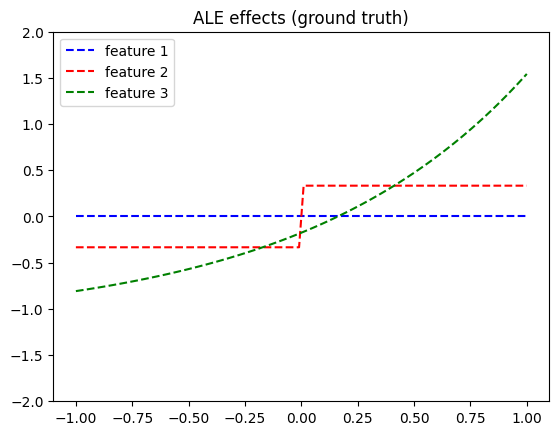

In [12]:
xx = np.linspace(-1, 1, 100)
y_ale = []
for feature in [0, 1, 2]:
    y_ale.append(ale_ground_truth(feature, xx))
    
plt.figure()
plt.title("ALE effects (ground truth)")
color_pallette = ["blue", "red", "green"]
for feature in [0, 1, 2]:
    plt.plot(
        xx, 
        y_ale[feature], 
        color=color_pallette[feature], 
        linestyle="--",
        label=f"feature {feature + 1}"
    )
plt.legend()
plt.xlim([-1.1, 1.1])
plt.ylim([-2, 2])
plt.show()
    

In [13]:
xx = np.linspace(-1, 1, 100)
for feature in [1]:# [0, 1, 2]:
    y_ale = ale.eval(feature=feature, xs=xx, centering=True)
    y_gt = ale_ground_truth(feature, xx)
    
    # hack to remove the effect at undefined region
    if feature == 1:
        K = 31
        ind = np.logical_and(xx > -1/K, xx < 1/K)
        y_ale[ind] = 0
        y_gt[ind] = 0
    
    np.testing.assert_allclose(y_ale, y_gt, atol=1e-1)
    

### Conclusions

Are the ALE effects intuitive?

ALE effects are identical to PDP effects which, as discussed above, can be considered intutive.

## RHALE

### Effector

Let's see below the RHALE effects for each feature, using `effector`.

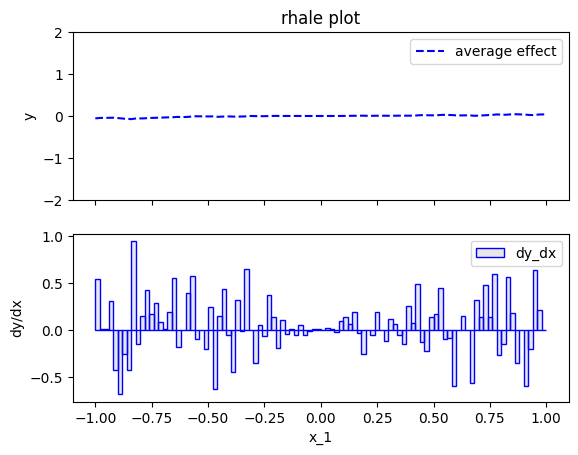

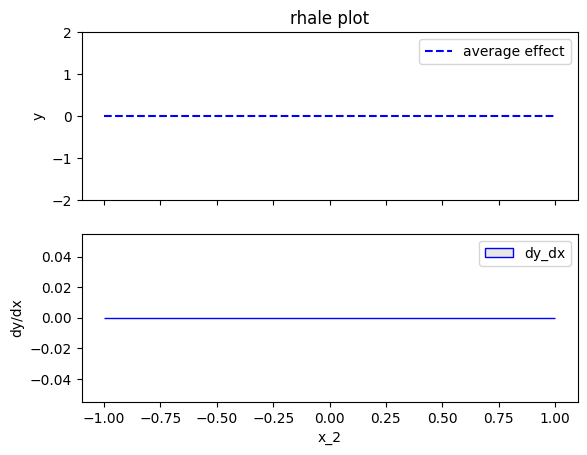

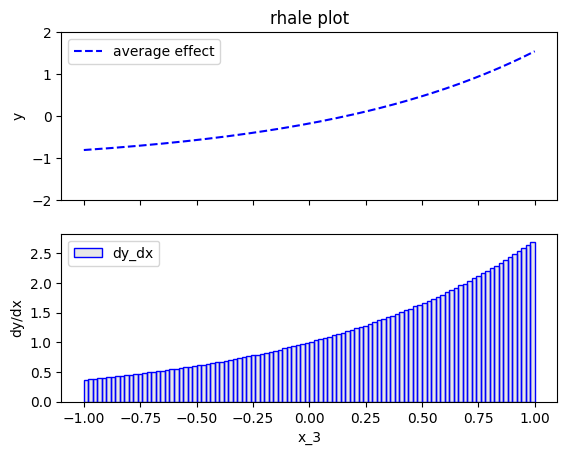

In [14]:
rhale = effector.RHALE(x, model.predict, model.jacobian, axis_limits=dataset.axis_limits)
rhale.fit(features="all", centering=True)

for feature in [0, 1, 2]:
    rhale.plot(feature=feature, centering=True, y_limits=[-2, 2])

RHALE states that:
- $x_1$ has a zero average effect on the model output (same as PDP)
- $x_2$ has a zero average effect on the model output (different than PDP and ALE)
- $x_3$ has an effect of $e^{x_3}$ (same as PDP)


### Derivations

\begin{align}
RHALE(x_1) &\propto \sum_{k=1}^{k_{x_1}} \frac{1}{| \mathcal{S}_k |} (z_k - z_{k-1}) \sum_{i: x^i \in \mathcal{S}_k} \left [  \frac{\partial f}{\partial x_1}(\mathbf{x}^i) \right ] \\
&\propto \sum_{k=1}^{k_{x_1}} \frac{1}{| \mathcal{S}_k |} (z_k - z_{k-1}) \sum_{i: x^{(i)} \in \mathcal{S}_k} \left [ -2x_1 \mathbb{1}_{x_2^i <0} + 2x_1 \mathbb{1}_{x_2^i \geq 0}  \right ] \\
&\propto \sum_{k=1}^{k_{x_1}} \frac{1}{| \mathcal{S}_k |} (z_k - z_{k-1}) \sum_{i: x^{(i)} \in \mathcal{S}_k} \left [ -2x_1 \underbrace{(\mathbb{1}_{x_2^i <0} - \mathbb{1}_{x_2^i \geq 0})}_{\approx 0} \right ] \\
&\approx \sum_{k=1}^{k_{x_1}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} 0 \\
&\approx 0
\end{align}

\begin{align}
RHALE(x_2) &\propto \sum_{k=1}^{k_{x_2}} \frac{1}{| \mathcal{S}_k |} (z_k - z_{k-1}) \sum_{i: x^i \in \mathcal{S}_k} \left [  \frac{\partial f}{\partial x_2}(\mathbf{x}^i) \right ] \\
&\propto \sum_{k=1}^{k_{x_2}} \frac{1}{| \mathcal{S}_k |} (z_k - z_{k-1}) \sum_{i: x^i \in \mathcal{S}_k} \cases{0 \text{ if $x_2 <0$} \\ 0 \text{ if $x_2 \geq 0$}}  \\
&\propto 0
\end{align}

\begin{align}
RHALE(x_3) &\propto \sum_{k=1}^{k_{x_3}} \frac{1}{| \mathcal{S}_k |} (z_k - z_{k-1}) \sum_{i: x^i \in \mathcal{S}_k} \left [  \frac{\partial f}{\partial x_3}(\mathbf{x}^i) \right ] \\
&\propto \sum_{k=1}^{k_{x_3}} \frac{1}{| \mathcal{S}_k |} (z_k - z_{k-1}) \sum_{i: x^i \in \mathcal{S}_k} \left [ e^{x_3} \right ] \\
&\approx e^{x_3}
\end{align}

In [15]:
def rhale_ground_truth(feature, xs):
    if feature == 0:
        ff = lambda x: np.zeros_like(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 1:
        K = 31
        ff = lambda x: np.zeros_like(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 2:
        ff = lambda x: np.exp(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z


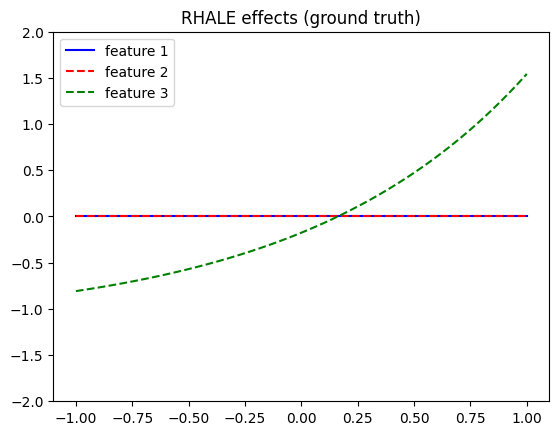

In [16]:
xx = np.linspace(-1, 1, 100)
y_rhale = []
for feature in [0, 1, 2]:
    y_rhale.append(rhale_ground_truth(feature, xx))
    
plt.figure()
plt.title("RHALE effects (ground truth)")
color_pallette = ["blue", "red", "green"]
for feature in [0, 1, 2]:
    plt.plot(
        xx, 
        y_rhale[feature], 
        color=color_pallette[feature], 
        linestyle="-" if feature == 0 else "--",
        label=f"feature {feature + 1}"
    )
plt.legend()
plt.xlim([-1.1, 1.1])
plt.ylim([-2, 2])
plt.show()



In [17]:
for feature in [0, 1, 2]:
    y_ale = rhale.eval(feature=feature, xs=xx, centering=True)
    y_gt = rhale_ground_truth(feature, xx)
    np.testing.assert_allclose(y_ale, y_gt, atol=1e-1)

### Conclusions

Are the RHALE effects intuitive?

RHALE does not add something new, compared to ALE and PDP, for features $x_1$ and $x_3$. 
For $x_2$, however, it does not capture the abrupt increase by $+\frac{2}{3}$ units when moving from $x_2^-$ to $x_2^+$, which can be considered as an error mode of RHALE. In fact, RHALE requires a differentiable black box model, and since $f$ is not differentiable with respect to $x_2$, that is why we get a slightly misleading result.